In [1]:
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import KMeans
from math import *
import matplotlib.pyplot as plt

### 데이터 로드, longitude 태평양중심

In [2]:
data = pd.read_csv('C:/Users/renz/Downloads/1205_data.csv')
data['LON'] = data['LON'].apply(lambda x : (x - 360) if x>0 else x )

### MMSI3 그룹화해서 개수 보기

In [3]:
data.groupby('MMSI3').count()['MMSI'].head()

MMSI3
209087000_4_1    141
209087000_4_2     47
209087000_8_2     48
209087000_8_3     39
209087000_8_5     94
Name: MMSI, dtype: int64

### MMSI3 기준으로 배가 몇개인지 확인

In [4]:
len(data.groupby('MMSI3').count())

2783

##### 배 경로 시각화(간단 코드)

In [193]:
data1 = data[data['MMSI3']=='636092379_83_3']
data1 = data1.reset_index()
m = folium.Map(location=[data1.loc[0,'LAT'], data1.loc[0,'LON']], zoom_start=1)
for i in range(data1.shape[0]):
    folium.CircleMarker(location=[data1.loc[i,'LAT'], data1.loc[i,'LON']], color = 'red', radius = 0.05).add_to(m)
m

KeyError: 'the label [0] is not in the [index]'

### train, test set 나누기

In [5]:
test = pd.concat([data, pd.DataFrame({'ETA4':data['ETA3'].apply(lambda x: x[:7].replace('-', ''))})], axis = 1).groupby('MMSI3').first().reset_index()
test2 = test[test['ETA4'].apply(lambda x: x in ['201808', '201807'])]
test3 = data[data['MMSI3'].isin(test2['MMSI3'])]

In [6]:
train = data[data.MMSI3.isin(test3.MMSI3) == False] 

In [7]:
data = train

### 도착지점에 대하여...(가장 많은 도착지점은 어떤 항구인가?)

##### 항구가져오기

In [8]:
port = pd.read_csv('C:/Users/renz/Downloads/DATA/PORT_MERGE_out.csv')

In [9]:
df1 = data.groupby('MMSI3').last()
L2 = []
for i,j,k in zip(df1.index, df1['LAT'], df1['LON']):
    L1 = []
    for l1, l2 in zip(port['LAT'], port['LON']):
        R = 6373.0 
        lat1 = radians(j) 
        lon1 = radians(k) 
        lat2 = radians(l1) 
        lon2 = radians(l2) 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
        c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
        distance = R * c
        L1.append(distance)
    L2.append([min(L1), port.iloc[L1.index(min(L1)),0], port.iloc[L1.index(min(L1)),1], port.iloc[L1.index(min(L1)),2]])

##### 2828개의 ship, 옆에 LAT, LON 붙이기

In [10]:
port_count = pd.DataFrame(L2, columns = ['distance', 'port_id', 'LAT', 'LON']).reset_index(drop=True).groupby('port_id').agg({'distance':'count', 'LAT':'mean', 'LON':'mean'}).reset_index().sort_values(by='distance', ascending=False)
df2 = port_count[port_count.port_id.isin(['USOAK', 'USLGB', 'KRPUS', 'JPSHS', 'MXZLO', 'CNYTN'])].reset_index(drop=False)
df2

,index,port_id,distance,LAT,LON
0,89,USOAK,235,37.797840,-122.286404
1,63,KRPUS,136,35.101620,-230.963950
2,88,USLGB,122,33.754929,-118.214344
3,52,JPSHS,118,33.937665,-229.076200
4,68,MXZLO,83,19.077290,-104.322500
5,32,CNYTN,70,22.575000,-245.723499


### 도착지(어떤 항구)를 기준으로 5km이내 모든 경로 가져오기

In [11]:
def port_5km(data, lat, lon):
    data1 = data.groupby(['MMSI3']).last()
    L1 = []
    
    for i,j,k in zip(data1.index, data1['LAT'], data1['LON']):
        R = 6373.0 
        lat1 = radians(j) 
        lon1 = radians(k) 
        lat2 = radians(lat) 
        lon2 = radians(lon)
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
        c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
        distance = R * c
        L1.append(distance)

    df1 = pd.DataFrame(list(zip(data1.index, L1)), columns = ['MMSI3', 'distance'])
    df2 = df1[df1['distance'] <= 5]['MMSI3'].tolist()
    df3 = data[data['MMSI3'].isin(df2)].reset_index(drop=True)
    
    return df3

In [435]:
# 필요한 항구 정보를 넣자.
port_id = 'USOAK'
port_ais = port_5km(data=data, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])
# port_ais

### port_ais를 이용하여 10분위 수 가져오기

In [436]:
def ten_number(data):
    L1 = list()
    for i, j in data.groupby('MMSI3').agg({'MMSI3': 'unique', 'MMSI': 'count'}).reset_index(drop=True).apply(lambda x: (x.MMSI3[0], x.MMSI), axis=1).tolist():
        for k in range(0, 11, 1):
            k = k/10
            df1 = data[data['MMSI3'] == i][['MMSI3', 'LAT', 'LON']].reset_index()
            
            if k == 0:
                L2 = list()
                L2.extend(list(df1[['MMSI3', 'LAT', 'LON']].iloc[0, :]))
            elif 0 < k < 1:
                L2.extend(list(df1[['LAT', 'LON']].iloc[int(round(j*k)), :]))
            else:
                L2.extend(list(df1[['LAT', 'LON']].iloc[-1, :]))
        L1.append(L2)

    L2 = pd.DataFrame(L1)
    
    
    if pd.isnull(L2).sum().sum() != 0:
        print('exist null...!!!!!')
    
    return L2

In [437]:
df3 = ten_number(port_ais)
# df3

### k means clustring(계층적으로....)

In [438]:
def visualization(data, sorted_L, i):
    print(i)
    data3 = data
    L = sorted_L
    for i, j in enumerate(L):
        data_cluster = data3[np.array(data3.iloc[:,-1:]).tolist() == j][['MMSI3', 'LAT', 'LON']]
        L2 = data_cluster['MMSI3'].unique()
        for k in L2:
                plt.subplot(1, 2, i+1)
                plt.plot(data_cluster[data_cluster['MMSI3'] == k]['LON'], data_cluster[data_cluster['MMSI3'] == k]['LAT'], 
                         'rs--', linewidth = .1, markersize = .1)
    
    return plt.show()

In [439]:
def mean_test(data):
    mean = data.describe().loc['mean',:]

    L = list()
    for i,j in zip(mean, data.columns):
        sum = 0
        for k in data.index:
            sum = sum + (i-data[j][k])**2
#             sum = sum + abs(i-data[j][k])
        L.append(round(sum,2))
    L1 = np.mean(L)
    
    return round(L1, 2)

In [582]:
def deepen(data, ten_number_data):
    data3 = data
    
    data_depth2_1 = data3[data3['cluster']==0].reset_index(drop=True)
    data_depth2_2 = data3[data3['cluster']==1].reset_index(drop=True)

    X_depth2_1 = np.array(ten_number_data[ten_number_data[0].isin(data_depth2_1['MMSI3'].unique())].iloc[:,1:])
    X_depth2_2 = np.array(ten_number_data[ten_number_data[0].isin(data_depth2_2['MMSI3'].unique())].iloc[:,1:])

    if X_depth2_1.shape[0] > 1:
        kmeans_depth2_1 = KMeans(n_clusters=2, random_state=0).fit(X_depth2_1)
        del data_depth2_1['cluster']
        depth2_1 = pd.DataFrame({'MMSI3' : ten_number_data[ten_number_data[0].isin(data_depth2_1['MMSI3'].unique())].iloc[:,0].tolist(), 'cluster' : list(kmeans_depth2_1.labels_)})
        depth2_1_mg = pd.merge(data_depth2_1, depth2_1, how='left', on=['MMSI3'])
    else:
        depth2_1_mg = data_depth2_1
        
    if X_depth2_2.shape[0] > 1:
        kmeans_depth2_2 = KMeans(n_clusters=2, random_state=0).fit(X_depth2_2)
        del data_depth2_2['cluster']
        depth2_2 = pd.DataFrame({'MMSI3' : ten_number_data[ten_number_data[0].isin(data_depth2_2['MMSI3'].unique())].iloc[:,0].tolist(), 'cluster' : list(kmeans_depth2_2.labels_)})
        depth2_2_mg = pd.merge(data_depth2_2, depth2_2, how='left', on=['MMSI3'])
    else:
        depth2_2_mg = data_depth2_2

    return depth2_1_mg, depth2_2_mg    

In [595]:
def input_calculate(data, ten_number_data):
    data_depth2_1 = data[data['cluster']==0].reset_index(drop=True)
    data_depth2_2 = data[data['cluster']==1].reset_index(drop=True)
    
    df1 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(data_depth2_1['MMSI3'].unique())])
    mean_result1 = mean_test(data=df1.groupby([0]).mean())
    df2 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(data_depth2_2['MMSI3'].unique())])
    mean_result2 = mean_test(data=df2.groupby([0]).mean())
    return mean_result1, mean_result2

In [615]:
def kmeans_clustering(port_ais_data, ten_number_data):
    df1 = port_ais_data
    df2 = ten_number_data.iloc[:,1:]
    
    df3 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(df1['MMSI3'].unique())])
    df3.rename(columns={0:'MMSI3'}, inplace=True)
    
    # MMSI3가 없는 데이터로 kmeans 실행
    kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(df2))
    
    df_mmsi3_cluster = pd.DataFrame({'MMSI3' : ten_number_data.loc[:,0].tolist(), 'cluster' : list(kmeans.labels_)})
    df4 = pd.merge(df1, df_mmsi3_cluster, how='left', on=['MMSI3'])
    
    df5 = df4[['MMSI3', 'LAT', 'LON']]
    for k in df4['MMSI3'].unique():
            plt.plot(df5[df4['MMSI3'] == k]['LON'], df5[df4['MMSI3'] == k]['LAT'], 'rs--', linewidth = .1, markersize = .1)
    plt.show()
    
    
    # Depth 1
    plt.figure(figsize=(5, 2))
    visualization(data=df4, sorted_L=sorted(df4['cluster'].unique()), i='Depth 1')
    
    input_calculate1, input_calculate2 = input_calculate(data=df4, ten_number_data=ten_number_data)
    print("Depth 1 1번째 편차 : {}".format(input_calculate1))
    print("Depth 1 2번째 편차 : {}\n".format(input_calculate2))
    
    if input_calculate1 > 25:
        depth2_1_mg, depth2_2_mg = deepen(data=df4, ten_number_data=ten_number_data)
        plt.figure(figsize=(4, 2))
        visualization(data=depth2_1_mg, sorted_L=sorted(depth2_1_mg['cluster'].unique()), i='Depth 2')
        input_calculate3, input_calculate4 = input_calculate(data=depth2_1_mg, ten_number_data=ten_number_data)
        print("Depth 1 1번째 편차, Depth 2 1번째 편차 : {}".format(input_calculate3))
        print("Depth 1 1번째 편차, Depth 2 2번째 편차 : {}\n".format(input_calculate4))
        
        if input_calculate3 > 25:
            depth3_1_1_mg, depth3_1_2_mg = deepen(data=depth2_1_mg, ten_number_data=ten_number_data)
            plt.figure(figsize=(4, 2))
            visualization(data=depth3_1_1_mg, sorted_L=sorted(depth3_1_1_mg['cluster'].unique()), i='Depth 3')
            input_calculate5, input_calculate6 = input_calculate(data=depth3_1_1_mg, ten_number_data=ten_number_data)
            print("Depth 1 1번째 편차, Depth 2 1번째 편차, Depth 3 1번째 편차 : {}".format(input_calculate5))
            print("Depth 1 1번째 편차, Depth 2 1번째 편차, Depth 3 2번째 편차 : {}\n".format(input_calculate6))
            
            if input_calculate5 > 25:
                depth4_1_1_1_mg, depth4_1_1_2_mg = deepen(data=depth3_1_1_mg, ten_number_data=ten_number_data)
                plt.figure(figsize=(4, 2))
                visualization(data=depth4_1_1_1_mg, sorted_L=sorted(depth4_1_1_1_mg['cluster'].unique()), i='Depth 4')
                input_calculate7, input_calculate8 = input_calculate(data=depth4_1_1_1_mg, ten_number_data=ten_number_data)
                print("Depth 1 1번째 편차, Depth 2 1번째 편차, Depth 3 1번째 편차, Depth 4 1번째 편차 : {}".format(input_calculate7))
                print("Depth 1 1번째 편차, Depth 2 1번째 편차, Depth 3 1번째 편차, Depth 4 2번째 편차 : {}\n".format(input_calculate8))

            if input_calculate6 > 25:
                plt.figure(figsize=(4, 2))
                visualization(data=depth4_1_1_2_mg, sorted_L=sorted(depth4_1_1_2_mg['cluster'].unique()), i='Depth 4')
                input_calculate9, input_calculate10 = input_calculate(data=depth4_1_1_2_mg, ten_number_data=ten_number_data)
                print("Depth 1 1번째 편차, Depth 2 1번째 편차, Depth 3 2번째 편차, Depth 4 3번째 편차 : {}".format(input_calculate9))
                print("Depth 1 1번째 편차, Depth 2 1번째 편차, Depth 3 2번째 편차, Depth 4 4번째 편차 : {}\n".format(input_calculate10))
                      
        if input_calculate4 > 25:
            depth3_2_1_mg, depth3_2_2_mg = deepen(data=depth3_1_2_mg, ten_number_data=ten_number_data)
            plt.figure(figsize=(4, 2))
            visualization(data=depth3_1_2_mg, sorted_L=sorted(depth3_1_2_mg['cluster'].unique()), i='Depth 3')
            input_calculate5, input_calculate6 = input_calculate(data=depth3_1_2_mg, ten_number_data=ten_number_data)
            print("Depth 1 1번째 편차, Depth 2 2번째 편차, Depth 3 1번째 편차 : {}".format(input_calculate5))
            print("Depth 1 1번째 편차, Depth 2 2번째 편차, Depth 3 2번째 편차 : {}\n".format(input_calculate6))
            
            if input_calculate5 > 25:
                depth4_2_1_1_mg, depth4_2_1_2_mg = deepen(data=depth3_2_1_mg, ten_number_data=ten_number_data)
                plt.figure(figsize=(4, 2))
                visualization(data=depth3_2_1_mg, sorted_L=sorted(depth3_2_1_mg['cluster'].unique()), i='Depth 4')
                input_calculate11, input_calculate12 = input_calculate(data=depth3_2_1_mg, ten_number_data=ten_number_data)
                print("Depth 1 1번째 편차, Depth 2 2번째 편차, Depth 3 1번째 편차, Depth 4 1번째 편차 : {}".format(input_calculate11))
                print("Depth 1 1번째 편차, Depth 2 2번째 편차, Depth 3 1번째 편차, Depth 4 2번째 편차 : {}\n".format(input_calculate12))
                
                if input_calculate11 > 25:
                    depth5_2_1_1_1_mg, depth5_2_2_2_2_mg = deepen(data=depth4_2_1_1_mg, ten_number_data=ten_number_data)
                    plt.figure(figsize=(4, 2))
                    visualization(data=depth4_2_1_1_mg, sorted_L=sorted(depth4_2_1_1_mg['cluster'].unique()), i='Depth 5')
                    input_calculate13, input_calculate14 = input_calculate(data=depth4_2_1_1_mg, ten_number_data=ten_number_data)
                    print("Depth 1 1번째 편차, Depth 2 2번째 편차, Depth 3 1번째 편차, Depth 4 1번째 편차, Depth 5 1번째 편차 : {}".format(input_calculate13))
                    print("Depth 1 1번째 편차, Depth 2 2번째 편차, Depth 3 1번째 편차, Depth 4 1번째 편차, Depth 5 2번째 편차 : {}\n".format(input_calculate14))
                
            if input_calculate6 > 25:
                depth4_2_2_1_mg, depth4_2_2_2_mg = deepen(data=depth3_2_2_mg, ten_number_data=ten_number_data)
                plt.figure(figsize=(4, 2))
                visualization(data=depth3_2_2_mg, sorted_L=sorted(depth3_2_2_mg['cluster'].unique()), i='Depth 4')
                input_calculate15, input_calculate16 = input_calculate(data=depth3_2_2_mg, ten_number_data=ten_number_data)
                print("Depth 1 1번째 편차, Depth 2 2번째 편차, Depth 3 2번째 편차, Depth 4 1번째 편차 : {}".format(input_calculate15))
                print("Depth 1 1번째 편차, Depth 2 2번째 편차, Depth 3 2번째 편차, Depth 4 2번째 편차 : {}\n".format(input_calculate16))
                
                if input_calculate16 > 25:
                    depth5_2_2_2_1_mg, depth5_2_2_2_2_mg = deepen(data=depth4_2_2_2_mg, ten_number_data=ten_number_data)
                    plt.figure(figsize=(4, 2))
                    visualization(data=depth4_2_2_2_mg, sorted_L=sorted(depth4_2_2_2_mg['cluster'].unique()), i='Depth 5')
                    input_calculate17, input_calculate18 = input_calculate(data=depth4_2_2_2_mg, ten_number_data=ten_number_data)
                    print("Depth 1 1번째 편차, Depth 2 2번째 편차, Depth 3 2번째 편차, Depth 4 2번째 편차, Depth 5 1번째 편차 : {}".format(input_calculate17))
                    print("Depth 1 1번째 편차, Depth 2 2번째 편차, Depth 3 2번째 편차, Depth 4 2번째 편차, Depth 5 1번째 편차 : {}\n".format(input_calculate18))
            
    
    # 오른쪽 가지 시작
    if input_calculate2 > 25:
        depth2_2_3_mg, depth2_2_4_mg = deepen(data=depth2_2_mg, ten_number_data=ten_number_data)
        plt.figure(figsize=(4, 2))
        visualization(data=depth2_2_mg, sorted_L=sorted(depth2_2_mg['cluster'].unique()), i='Depth 2')
        input_calculate19, input_calculate20 = input_calculate(data=depth2_2_mg, ten_number_data=ten_number_data)
        print("Depth1 2번째, Depth2 2번째, Depth3 1번째 편차 : {}".format(input_calculate19))
        print("Depth1 2번째, Depth2 2번째, Depth3 2번재 편차 : {}\n".format(input_calculate20))

        if input_calculate19 > 25:
            depth3_2_3_1_mg, depth3_2_3_2_mg = deepen(data=depth2_2_3_mg, ten_number_data=ten_number_data)
            plt.figure(figsize=(4, 2))
            visualization(data=depth2_2_3_mg, sorted_L=sorted(depth2_2_3_mg['cluster'].unique()), i='Depth 3')
            input_calculate21, input_calculate22 = input_calculate(data=depth2_2_3_mg, ten_number_data=ten_number_data)
            print("Depth1 2번째, Depth2 2번째, Depth3 1번째, Depth4 1번째 편차 : {}".format(input_calculate21))
            print("Depth1 2번째, Depth2 2번째, Depth3 1번재, Depth4 2번째 편차 : {}\n".format(input_calculate22))
            
            if input_calculate21 > 25:
                depth4_2_3_1_1_mg, depth4_2_3_1_2_mg = deepen(data=depth3_2_3_1_mg, ten_number_data=ten_number_data)
                plt.figure(figsize=(4, 2))
                visualization(data=depth3_2_3_1_mg, sorted_L=sorted(depth3_2_3_1_mg['cluster'].unique()), i='Depth 4')
                input_calculate25, input_calculate26 = input_calculate(data=depth3_2_3_1_mg, ten_number_data=ten_number_data)
                print("Depth1 2번째, Depth2 2번째, Depth3 1번째, Depth4 1번째, Depth5 1번째 편차 : {}".format(input_calculate25))
                print("Depth1 2번째, Depth2 2번째, Depth3 1번재, Depth4 1번째, Depth5 2번째 편차 : {}\n".format(input_calculate26))
                
        if input_calculate20 > 25:
            depth3_2_3_3_mg, depth3_2_3_4_mg = deepen(data=depth2_2_4_mg, ten_number_data=ten_number_data)
            plt.figure(figsize=(4, 2))
            visualization(data=depth2_2_4_mg, sorted_L=sorted(depth2_2_4_mg['cluster'].unique()), i='Depth 3')
            input_calculate23, input_calculate24 = input_calculate(data=depth2_2_4_mg, ten_number_data=ten_number_data)
            print("Depth1 2번째, Depth2 2번째, Depth3 2번째, Depth4 1번째 편차 : {}".format(input_calculate23))
            print("Depth1 2번째, Depth2 2번째, Depth3 2번재, Depth4 2번째 편차 : {}\n".format(input_calculate24))
            
            if input_calculate24 > 25:
                depth4_2_3_4_1_mg, depth4_2_3_4_2_mg = deepen(data=depth3_2_3_4_mg, ten_number_data=ten_number_data)
                plt.figure(figsize=(4, 2))
                visualization(data=depth3_2_3_4_mg, sorted_L=sorted(depth3_2_3_4_mg['cluster'].unique()), i='Depth 4')
                input_calculate27, input_calculate28 = input_calculate(data=depth3_2_3_4_mg, ten_number_data=ten_number_data)
                print("Depth1 2번째, Depth2 2번째, Depth3 2번째, Depth4 2번째, Depth5 1번째 편차 : {}".format(input_calculate27))
                print("Depth1 2번째, Depth2 2번째, Depth3 2번재, Depth4 2번째, Depth5 1번째 편차 : {}\n".format(input_calculate28))
                
        
    
    
    
    return

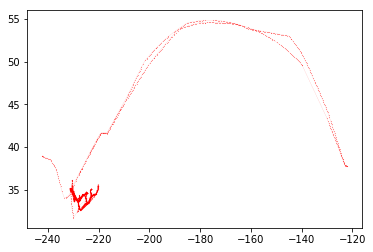

Depth 1


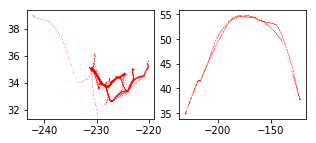

Depth 1 1번째 편차 : 251.18
Depth 1 2번째 편차 : 11.47

Depth 2


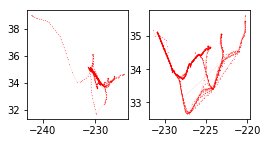

Depth 1 1번째 편차, Depth 2 1번째 편차 : 57.86
Depth 1 1번째 편차, Depth 2 2번째 편차 : 55.01

Depth 3


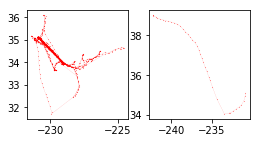

Depth 1 1번째 편차, Depth 2 1번째 편차, Depth 3 1번째 편차 : 21.26
Depth 1 1번째 편차, Depth 2 1번째 편차, Depth 3 2번째 편차 : 0.0

Depth 3


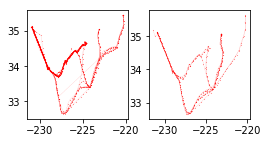

Depth 1 1번째 편차, Depth 2 2번째 편차, Depth 3 1번째 편차 : 25.34
Depth 1 1번째 편차, Depth 2 2번째 편차, Depth 3 2번째 편차 : 0.98

Depth 4


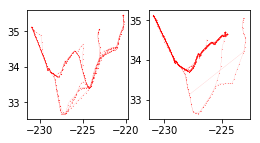

Depth 1 1번째 편차, Depth 2 2번째 편차, Depth 3 1번째 편차, Depth 4 1번째 편차 : 6.78
Depth 1 1번째 편차, Depth 2 2번째 편차, Depth 3 1번째 편차, Depth 4 2번째 편차 : 5.02



In [613]:
kmeans_clustering(port_ais_data=port_ais, ten_number_data=df3)

In [444]:
df2

,index,port_id,distance,LAT,LON
0,89,USOAK,235,37.797840,-122.286404
1,63,KRPUS,136,35.101620,-230.963950
2,88,USLGB,122,33.754929,-118.214344
3,52,JPSHS,118,33.937665,-229.076200
4,68,MXZLO,83,19.077290,-104.322500
5,32,CNYTN,70,22.575000,-245.723499


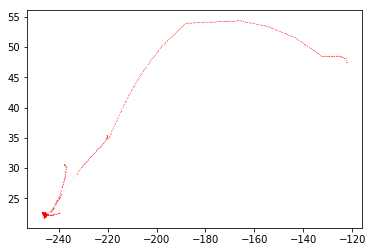

Depth 1


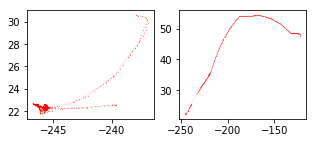

Depth 1 1번째 편차 : 75.6
Depth 1 2번째 편차 : 0.0

Depth 2


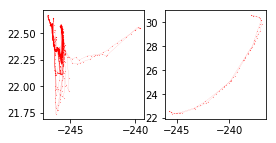

Depth 1 1번째 편차, Depth 2 1번째 편차 : 14.98
Depth 1 1번째 편차, Depth 2 2번째 편차 : 0.12



In [621]:
port_id = 'CNYTN'
port_ais = port_5km(data=data, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])
df3 = ten_number(port_ais)
cluster_data = kmeans_clustering(port_ais_data=port_ais, ten_number_data=df3)

In [628]:
cluster_data

In [591]:
cluster_data['clustering'] = cluster_data.cluster_x.apply(lambda x: str(x))+cluster_data.cluster_y.apply(lambda x: str(x))+cluster_data.cluster.apply(lambda x: str(int(x)))
cluster_data.clustering.unique()

AttributeError: 'NoneType' object has no attribute 'cluster_x'

In [58]:
cluster_data['clustering'] = cluster_data.cluster_x.apply(lambda x: str(x))+cluster_data.cluster_y.apply(lambda x: str(x))+cluster_data.cluster.apply(lambda x: str(int(x)))

### modeling 도착지점을 기반으로, test set 가져오기

In [64]:
# 필요한 항구 정보를 넣자.
port_id = 'USOAK'
test_port_ais = port_5km(data=test3, lat=df2.loc[df2.port_id.tolist().index(port_id), 'LAT'], lon=df2.loc[df2.port_id.tolist().index(port_id), 'LON'])
train_data = cluster_data
# test_port_ais

In [88]:
train = ten_number(train_data)
train.rename(columns={0:'MMSI3'}, inplace=True)

In [100]:
train2 = pd.merge(train, train_data[['MMSI3', 'clustering']], how = 'left', on = ['MMSI3']).groupby('clustering').mean().reset_index()

In [101]:
test4 = ten_number(test_port_ais)

In [102]:
train2

,clustering,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,003,33.748693,-118.251848,33.788428,-118.700503,34.057268,-119.439313,34.335031,-120.330384,34.733470,...,35.966284,-122.049199,36.563772,-122.425104,37.139692,-122.660076,37.656230,-122.652375,37.800643,-122.317335
1,013,43.073195,-122.353114,44.501918,-123.832248,45.820892,-124.553896,46.625192,-125.334331,46.680999,...,45.203874,-125.176743,42.619567,-125.080666,40.291730,-124.402221,38.854247,-124.071861,37.792324,-122.299149
2,100,-17.538470,-149.576318,-12.095847,-147.474109,-5.819910,-144.717027,0.170996,-142.238983,5.897495,...,16.704916,-135.075720,22.243320,-132.482932,27.741587,-129.755701,33.613479,-126.534594,37.794240,-122.306160
3,101,-14.294019,-170.668868,-9.024446,-164.723608,-3.454792,-158.817613,2.317632,-152.766395,7.820237,...,18.065326,-135.556912,23.288810,-129.250238,28.407311,-122.499868,33.193149,-118.034894,37.795620,-122.307276
4,110,-37.658985,-183.822600,-30.650976,-176.577781,-23.728987,-170.039675,-16.901127,-163.482524,-8.061488,...,7.746057,-146.198106,15.883775,-140.528430,24.151188,-134.632778,32.658158,-127.973358,37.793565,-122.302388
5,111,-37.859200,-215.084000,-34.050400,-207.871300,-34.053900,-189.733900,-35.340100,-181.910700,-25.119500,...,-3.693400,-157.421000,6.702900,-149.600400,16.950900,-141.719900,27.683300,-132.991700,37.792400,-122.305400


In [103]:
test4

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,255805930_33_1,33.7529,-118.2343,33.7461,-118.5807,34.0388,-119.1835,34.2346,-119.9449,34.3914,...,35.4931,-121.8038,36.3033,-122.3013,37.1103,-122.6131,37.6662,-122.6665,37.7920,-122.3034
1,538004202_35_1,33.7645,-118.2743,33.7508,-118.5778,34.0183,-119.1452,34.2473,-120.0431,34.4958,...,35.7243,-121.9303,36.4437,-122.2799,37.2054,-122.6515,37.6820,-122.6682,37.8116,-122.3339
2,564345000_62_1,33.7465,-118.2724,33.7528,-118.5730,34.0560,-119.2229,34.2116,-119.8706,34.4580,...,35.7206,-121.9809,36.5195,-122.3746,37.0198,-122.6241,37.7503,-122.6807,37.8100,-122.3374
3,636018189_4_1,33.7622,-118.2758,33.7606,-118.5965,34.0771,-119.2715,34.2242,-119.9263,34.4406,...,35.7878,-121.7974,36.5023,-122.2826,37.0124,-122.5399,37.7122,-122.6962,37.7948,-122.3127
4,636091912_41_5,-17.5387,-149.5751,-11.9694,-147.4324,-6.1572,-144.7414,-0.1760,-141.9964,5.7495,...,17.0647,-133.9875,22.4429,-131.3678,27.7501,-128.6822,33.0481,-125.8708,37.7923,-122.2944


In [175]:
L = []
for i in test4.index:
    L2 = []
    for j in train2.index:
        sum = 0
        for l1,l2 in zip(test4.iloc[i,1:], train2.iloc[j,1:]):
            sum = sum + (l1-l2)**2
        L2.append(sum)
    L.append(train2.clustering[L2.index(min(L2))])
test5 = pd.DataFrame({'MMSI3':test4[0], 'clustering':L})

In [176]:
test5

,MMSI3,clustering
0,255805930_33_1,003
1,538004202_35_1,003
2,564345000_62_1,003
3,636018189_4_1,003
4,636091912_41_5,100


In [353]:
train6 = train_data[train_data.clustering == '003']
train6.drop(['cluster_x', 'cluster_y', 'cluster', 'clustering', 'MMSI2', 'MMSI'], inplace=True, axis=1)

In [362]:
test6 = test_port_ais[test_port_ais.MMSI3.isin(test5[test5['clustering']=='003']['MMSI3'])]
test6.drop(['MMSI2', 'MMSI'], inplace=True, axis=1)

In [383]:
import datetime 
def Y_Value(x) : 
    x['ETA'] = x['ETA'].astype(str).apply(lambda x: x[0:19])
    x['ETA'] = x['ETA'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    lastTime = x.groupby('MMSI3').last()['ETA'].reset_index()
    lastTime.columns = ['MMSI3','LAST_ETA']
    x = pd.merge(x, lastTime , on = 'MMSI3')
    x['y_value'] = (x['LAST_ETA'] - x['ETA']) /np.timedelta64(1, 'h')
    return x

In [384]:
train67 = Y_Value(train6)

In [420]:
test77 = test6[['LAT', 'LON']]

In [421]:
train77 = train67[['LAT', 'LON', 'y_value']]

### modeling and predictions

In [391]:
import sklearn
from sklearn.linear_model import LinearRegression

In [422]:
regr = LinearRegression()

In [424]:
regr.fit(train77[['LAT', 'LON']], train77[['y_value']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [425]:
y_pred = regr.predict(test77)

In [426]:
test6['ETA'] = test6['ETA'].apply(lambda x: str(x)+':00')
y_test = Y_Value(test6)['y_value']

In [427]:
y_sqrt = []
for i,j in zip(y_pred, y_test):
    y_sqrt.append((float(i)-float(j))**2)

In [428]:
np.sqrt(np.mean(y_sqrt))

4.206528540947065

In [405]:
train6 = train_data[train_data.clustering == '100']
train6.drop(['cluster_x', 'cluster_y', 'cluster', 'clustering', 'MMSI2', 'MMSI'], inplace=True, axis=1)

In [406]:
test6 = test_port_ais[test_port_ais.MMSI3.isin(test5[test5['clustering']=='100']['MMSI3'])]
test6.drop(['MMSI2', 'MMSI'], inplace=True, axis=1)

In [409]:
train6['ETA'] = train6['ETA'].apply(lambda x: str(x)+':00')
train67 = Y_Value(train6)

In [410]:
test77 = test6[['LAT', 'LON', 'SPEED']]

In [411]:
train77 = train67[['LAT', 'LON', 'SPEED', 'y_value']]

### modeling and predictions

In [412]:
import sklearn
from sklearn.linear_model import LinearRegression

In [413]:
regr = LinearRegression()

In [414]:
regr.fit(train77[['LAT', 'LON', 'SPEED']], train77[['y_value']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [415]:
y_pred = regr.predict(test77)

In [416]:
test6['ETA'] = test6['ETA'].apply(lambda x: str(x)+':00')
y_test = Y_Value(test6)['y_value']

In [417]:
y_sqrt = []
for i,j in zip(y_pred, y_test):
    y_sqrt.append((float(i)-float(j))**2)

In [418]:
np.sqrt(np.mean(y_sqrt))

3.7850017743727453

In [ ]:
def kmeans_clustering(port_ais_data, ten_number_data):
    df1 = port_ais_data
    data22 = ten_number_data.iloc[:,1:]
    
    df2 = pd.DataFrame(ten_number_data[ten_number_data[0].isin(df1['MMSI3'].unique())])
    mean_test(data=df2.groupby([0]).mean())
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(np.array(data22))

    data2 = pd.DataFrame({'MMSI3' : ten_number_data.loc[:,0].tolist(), 'cluster' : list(kmeans.labels_)})
    data3 = pd.merge(df1, data2, how='left', on=['MMSI3'])
    
    
#     print(data3) 얘는 맨 처음 clustering 한 내용. 기본 data + cluster_1 정보 들어있음.
    
    L = sorted(data3['cluster'].unique())
    
    # DEPTH 1
    plt.figure(figsize=(5, 2))
    visualization(data=data3, sorted_L=L, i='Depth 1')
    
    print(input_calculate(data=data3, ten_number_data=ten_number_data))
    
    # DEPTH 2
    depth2_1_mg, depth2_2_mg = deepen(data=data3, ten_number_data=ten_number_data)
    
    df11, df12 = input_calculate(data=depth2_1_mg, ten_number_data=ten_number_data)
    df21, df22 = input_calculate(data=depth2_2_mg, ten_number_data=ten_number_data)
    
    if df11 < 25 and df12 < 25:
        plt.figure(figsize=(3, 2))
        visualization(data=depth2_1_mg, sorted_L=sorted(np.unique(depth2_1_mg.iloc[:,-1:])), i='Depth2-1')
        plt.figure(figsize=(3, 2))
        visualization(data=depth2_2_mg, sorted_L=sorted(np.unique(depth2_2_mg.iloc[:,-1:])), i='Depth2-2')
    
    
    # join
    data4 = pd.merge(data3, pd.DataFrame(pd.concat([depth2_1_mg.groupby('MMSI3').first()['cluster'], depth2_2_mg.groupby('MMSI3').first()['cluster']])), how='left', on=['MMSI3'])
    
    
    print(input_calculate(data=depth2_1_mg, ten_number_data=ten_number_data))
    print(input_calculate(data=depth2_2_mg, ten_number_data=ten_number_data))
    
    # DEPTH 3
    if df11 >= 25 and df12 >= 25:
        depth3_1_mg, depth3_2_mg = deepen(data=depth2_1_mg, ten_number_data=ten_number_data)
        plt.figure(figsize=(2, 1))
        visualization(data=depth3_1_mg, sorted_L=sorted(np.unique(depth3_1_mg.iloc[:,-1:])), i='2-1 - Depth3-1')
        plt.figure(figsize=(2, 1))
        visualization(data=depth3_2_mg, sorted_L=sorted(np.unique(depth3_2_mg.iloc[:,-1:])), i='2-1 - Depth3-2')

        print(input_calculate(data=depth3_1_mg, ten_number_data=ten_number_data))
        print(input_calculate(data=depth3_2_mg, ten_number_data=ten_number_data))
    
    if df21 >= 25 and df22 >= 25:
        depth3_3_mg, depth3_4_mg = deepen(data=depth2_2_mg, ten_number_data=ten_number_data)
        plt.figure(figsize=(2, 1))
        visualization(data=depth3_3_mg, sorted_L=sorted(np.unique(depth3_3_mg.iloc[:,-1:])), i='2-2 - Depth3-3')
        plt.figure(figsize=(2, 1))
        visualization(data=depth3_4_mg, sorted_L=sorted(np.unique(depth3_4_mg.iloc[:,-1:])), i='2-2 - Depth3-4')
        
        print(input_calculate(data=depth3_3_mg, ten_number_data=ten_number_data))
        print(input_calculate(data=depth3_4_mg, ten_number_data=ten_number_data))
        
    # join
    if df11 >= 25 and df12 >= 25 and df21 >= 25 and df22 >= 25:
        data5 = pd.merge(data4, pd.DataFrame(pd.concat([depth3_1_mg.groupby('MMSI3').first()['cluster'], depth3_2_mg.groupby('MMSI3').first()['cluster'], depth3_3_mg.groupby('MMSI3').first()['cluster'], depth3_4_mg.groupby('MMSI3').first()['cluster']])), how='left', on=['MMSI3'])
    elif df11 >= 25 and df12 >= 25:
        data5 = pd.merge(data4, pd.DataFrame(pd.concat([depth3_1_mg.groupby('MMSI3').first()['cluster'], depth3_2_mg.groupby('MMSI3').first()['cluster']])), how='left', on=['MMSI3']).fillna(3)
    else:
        data5 = pd.merge(data4, pd.DataFrame(pd.concat([depth3_3_mg.groupby('MMSI3').first()['cluster'], depth3_4_mg.groupby('MMSI3').first()['cluster']])), how='left', on=['MMSI3']).fillna(3)
        
    return data5

In [22]:
import warnings
warnings.filterwarnings("ignore")